# Analysis template

**Begin code you never have to run after running once**

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [182]:
import copy
import os

import pandas as pd
import numpy as np

from scipy.stats import pearsonr

from tqdm import tqdm
#import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import joblib
import itertools
from pathlib import Path

from IPython.display import display, Markdown, Latex

home = str(Path.home())

import sys
sys.path.insert(0,"%s/rankability_toolbox_dev"%home)
import pyrankability

sys.path.insert(0,"%s/us_news_world_report_study"%home)
import base

**End code you never have to run after running once**

In [180]:
!ls ../data/*.txt

../data/usNewsData2012.txt  ../data/usNewsData2013.txt


## Options to select

**First select problem**

In [183]:
problem="usNewsData2012"

year = base.read_instance(problem).set_index('College')
year

,Overall Rank,Overall Score,Academic Reputation,Selectivity Rank,SAT (VM) 25-75th percentile,Percent freshmen top 10% HS Class,Acceptance,Faculty resource,Percent classes < 20 students,Percent classes >= 50 students,Student/Faculty ratio,Percent faculty full time,Graduation retention rank,Freshman retention,Financial resource rank,Alumni giving rank,Average Alumni giving rate
College,,,,,,,,,,,,,,,,,
Williams,1,100,93,3,1420.0,90,19,3,71,3.0,7,96,1,97,6,3,58
Amherst,2,98,91,3,1440.0,87,15,5,73,3.0,8,94,1,98,9,2,57
Swarthmore,3,96,90,6,1435.0,84,16,5,77,2.0,8,93,4,97,9,14,46
Middlebury,5,93,86,6,1385.0,86,17,23,68,3.0,9,94,10,96,5,3,55
Pomona,4,94,87,1,1470.0,91,15,20,71,1.0,7,94,3,98,8,19,43
Bowdoin,6,92,87,9,1405.0,83,20,14,68,3.0,9,94,10,97,12,11,50
Wellesley,6,92,89,11,1375.0,78,34,14,64,1.0,8,93,14,95,6,16,46
Carleton,6,92,87,11,1400.0,76,31,12,65,1.0,9,97,4,97,25,1,58
Haverford,10,90,81,2,1395.0,94,26,7,77,0.3,8,95,10,96,13,16,44


In [184]:
year.corr().loc['Overall Rank']

Overall Rank                         1.000000
Overall Score                       -0.978776
Academic Reputation                 -0.723034
Selectivity Rank                     0.665824
SAT (VM) 25-75th percentile         -0.539021
Percent freshmen top 10% HS Class   -0.671241
Acceptance                           0.699898
Faculty resource                     0.543604
Percent classes < 20 students       -0.251520
Percent classes >= 50 students       0.119162
Student/Faculty ratio                0.612099
Percent faculty full time           -0.362524
Graduation retention rank            0.806468
Freshman retention                  -0.703357
Financial resource rank              0.666622
Alumni giving rank                   0.371923
Average Alumni giving rate          -0.595697
Name: Overall Rank, dtype: float64

In [186]:
asc_ranking_columns = year.columns[year.corr().loc['Overall Rank'] > 0]
desc_ranking_columns = year.columns[year.corr().loc['Overall Rank'] < 0]

In [187]:
colleges = list(year.index)

**Print out your selections**

In [193]:
colleges_str=",".join(f'"{c}"' for c in colleges)
print(f'colleges = [{colleges_str}]')
print()
asc_ranking_columns_str=",".join(f'"{c}"' for c in asc_ranking_columns)
print(f'asc_ranking_columns = [{asc_ranking_columns_str}]')
print()
desc_ranking_columns_str=",".join(f'"{c}"' for c in desc_ranking_columns)
print(f'desc_ranking_columns = [{desc_ranking_columns_str}]')

colleges = ["Williams","Amherst","Swarthmore","Middlebury","Pomona","Bowdoin","Wellesley","Carleton","Haverford","Claremont McKenna","Vassar","Davidson","Harvey Mudd","US Naval Academy","Washington and Lee","Hamilton","Wesleyan","Colby","Colgate","Smith","Bates","Grinnell","Macalester","Bryn Mawr","Oberlin"]

asc_ranking_columns = ["Overall Rank","Selectivity Rank","Acceptance","Faculty resource","Percent classes >= 50 students","Student/Faculty ratio","Graduation retention rank","Financial resource rank","Alumni giving rank"]

desc_ranking_columns = ["Overall Score","Academic Reputation","SAT (VM) 25-75th percentile","Percent freshmen top 10% HS Class","Percent classes < 20 students","Percent faculty full time","Freshman retention","Average Alumni giving rate"]


**If you want to manually override this uncomment the following lines and edit them**

In [194]:
#colleges = ["Williams","Amherst","Swarthmore","Middlebury","Pomona","Bowdoin","Wellesley","Carleton","Haverford","Claremont McKenna","Vassar","Davidson","Harvey Mudd","US Naval Academy","Washington and Lee","Hamilton","Wesleyan","Colby","Colgate","Smith","Bates","Grinnell","Macalester","Bryn Mawr","Oberlin"]

#asc_ranking_columns = ["Overall Rank","Selectivity Rank","Acceptance","Faculty resource","Percent classes >= 50 students","Student/Faculty ratio","Graduation retention rank","Financial resource rank","Alumni giving rank"]

#desc_ranking_columns = ["Overall Score","Academic Reputation","SAT (VM) 25-75th percentile","Percent freshmen top 10% HS Class","Percent classes < 20 students","Percent faculty full time","Freshman retention","Average Alumni giving rate"]

## Shouldn't need to edit much below, but you will need to rerun if you change parameters above

## Converting to a D matrix
I expect we'll have some iterations and discussions on turning a year into a D matrix. Eventually, this code should be moved to base.py so everyone can share, but this is left for individual experimentation for now.

In [196]:
D = pd.DataFrame(index=year.index.copy(),columns=year.index.copy())
D.index.name = 'College1'
D.columns.name= 'College2'
for team1 in D.index:
    for team2 in D.columns:
        if team1 == team2:
            continue
        D.loc[team1,team2] = (year.loc[team1,asc_ranking_columns] < year.loc[team2,asc_ranking_columns]).sum()
        D.loc[team1,team2] += (year.loc[team1,desc_ranking_columns] > year.loc[team2,desc_ranking_columns]).sum()
D

College2,Williams,Amherst,Swarthmore,Middlebury,Pomona,Bowdoin,Wellesley,Carleton,Haverford,Claremont McKenna,...,Hamilton,Wesleyan,Colby,Colgate,Smith,Bates,Grinnell,Macalester,Bryn Mawr,Oberlin
College1,,,,,,,,,,,,,,,,,,,,,
Williams,NaN,9,12,13,9,15,15,12,13,14,...,15,16,16,16,15,15,16,16,16,15
Amherst,5,NaN,12,14,8,15,14,13,11,14,...,14,16,16,15,15,15,16,16,15,14
Swarthmore,4,2,NaN,11,7,13,12,11,11,11,...,13,13,16,15,16,15,16,16,16,16
Middlebury,2,1,5,NaN,3,8,13,7,7,7,...,11,12,16,15,12,14,13,16,15,12
Pomona,6,6,10,13,NaN,12,11,11,10,13,...,11,14,17,16,15,15,15,16,16,15
Bowdoin,0,0,3,4,3,NaN,10,6,9,7,...,12,13,16,15,12,14,13,16,15,13
Wellesley,1,2,2,4,5,4,NaN,4,5,8,...,8,9,14,15,14,13,14,15,15,13
Carleton,3,4,4,9,4,6,9,NaN,9,8,...,11,11,16,17,12,16,13,16,14,14
Haverford,4,5,4,8,7,7,10,8,NaN,8,...,15,10,16,16,15,14,15,16,15,15


## Rankability Analysis

In [204]:
delta_lop,details_lop = pyrankability.rank.solve(D,method='lop',cont=False)
delta_hillside,details_hillside = pyrankability.rank.solve(D,method='hillside',cont=False)

### Distance to perfection

In [205]:
delta_lop

1071

In [206]:
delta_hillside

1014

**Objective value for LOP (upper triangular reordered sum)**

In [207]:
details_lop['obj']

3667.0

### X*

In [208]:
delta_cont = {}
details_cont = {}
delta_cont['lop'],details_cont['lop'] = pyrankability.rank.solve(D,method='lop',cont=True)
delta_cont['hillside'],details_cont['hillside'] = pyrankability.rank.solve(D,method='hillside',cont=True)

In [209]:
label = "A"
xstars = {}
indices = {}
for method in delta_cont.keys():
    details = details_cont[method]
    xstar = pd.DataFrame(details['x'],index=D.index,columns=D.columns)
    xstars["%s. %s"%(label,method)] = xstar
    indices["%s. %s"%(label,method)] = details['indices']
    label = chr(ord(label)+1)
g,score_df,ordered_xstars = pyrankability.plot.show_score_xstar2(xstars,
                                                                 group_label="Group",width=300,height=300,
                                                                 columns=2,resolve_scale=True)
g

alt.FacetChart(...)

## Find pair in P with maximum number of discordant pairs

In [210]:
_,pair_max_tau_details = pyrankability.search.solve_pair_max_tau(D,method='lop',verbose=False,lazy=False)

**Tau**

In [211]:
pair_max_tau_details['tau']

0.9266666666666666

**Number of discorand pairs**

In [212]:
pair_max_tau_details['obj']

11.0

**Visual**

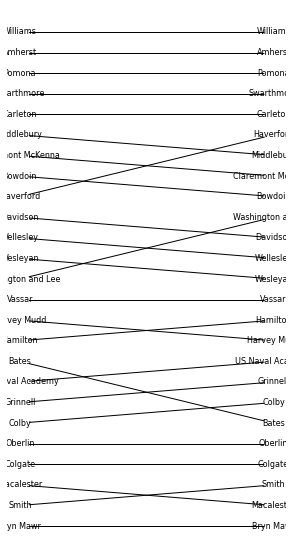

In [214]:
perm_x = np.array(pair_max_tau_details['perm_x'])
perm_y = np.array(pair_max_tau_details['perm_y'])
AB = pyrankability.plot.AB_to_P2(perm_x,perm_y)
AB_colleges = AB.copy()
for ix in AB_colleges.index:
    for c in AB_colleges.columns:
        v = AB_colleges.loc[ix,c]
        v = D.index[v]
        AB_colleges.loc[ix,c] = v
pyrankability.plot.spider(AB_colleges,file="visual1.png")

### Finding pairs within a tau range

See if there are any two solutions that are within a decent range of each other

In [219]:
tau_range=(0.8,0.99)
pair_tau_range_details=None
_,pair_tau_range_details = pyrankability.search.solve_pair_tau_range(tau_range,D,method='lop',verbose=False,lazy=False)
pair_tau_range_details['tau']

0.98

**Example about how to examine a pair**

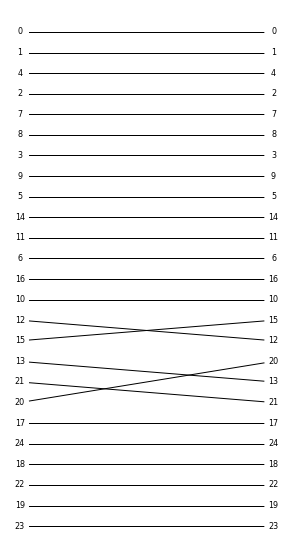

In [220]:
perm_x = np.array(pair_tau_range_details['perm_x'])
perm_y = np.array(pair_tau_range_details['perm_y'])
pyrankability.plot.spider(pyrankability.plot.AB_to_P2(perm_x,perm_y))

Now an example of what happens when you can't find a pair within the range

In [221]:
tau_range=(-0.001,0.001)
_,pair_tau_range_details = pyrankability.search.solve_pair_tau_range(tau_range,D,method='lop',verbose=False,lazy=False)

AttributeError: Unable to retrieve attribute 'X'

## Collect all solutions

In [222]:
delta_lop_with_models,details_lop_with_models = pyrankability.rank.solve(D,method='lop',cont=False,include_model=True)
delta_hillside_with_models,details_hillside_with_models = pyrankability.rank.solve(D,method='hillside',cont=False,include_model=True)

/home/jupyter-pander14/rankability_toolbox_dev/pyrankability/construct.py:81: RuntimeWarning: invalid value encountered in greater
  mask1 = np.abs(S[:,j]-S[:,i])>threshold # smooth things out and don't worry about warnings here
/home/jupyter-pander14/rankability_toolbox_dev/pyrankability/construct.py:82: RuntimeWarning: invalid value encountered in greater
  mask2 = np.abs(S[j,:]-S[i,:])>threshold # smooth things out and don't worry about warnings here


### LOP

In [223]:
model = details_lop_with_models['model']
model_file = pyrankability.common.write_model(model)
solution_file = model_file + ".solutions"
model_file

'/tmp/tmpwj4_k5td/model.mps'

In [224]:
!sed -i '/^OBJSENS/d' $model_file

In [225]:
!head $model_file

NAME lop
ROWS
 N  OBJ
 L  R0      
 G  R1      
 L  R2      
 G  R3      
 L  R4      
 G  R5      
 L  R6      


In [226]:
%%timeit
%%bash -s "$model_file" "$solution_file"
~/rankability_toolbox_dev/collect.sh $1 $2

Model file: /tmp/tmpwj4_k5td/model.mps
Solutions file: /tmp/tmpwj4_k5td/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmpwj4_k5td/model.mps
Solutions file: /tmp/tmpwj4_k5td/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmpwj4_k5td/model.mps
Solutions file: /tmp/tmpwj4_k5td/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmpwj4_k5td/model.mps
Solutions file: /tmp/tmpwj4_k5td/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmpwj4_k5td/model.mps
Solutions file: /tmp/tmpwj4_k5td/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmpwj4_k5td/model.mps
Solutions file: /tmp/tmpwj4_k5td/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmpwj4_k5td/model.mps
Solutions file: /tmp/tmpwj4_k5td/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmpwj4_k5td/model.mps
Solutions file: /tmp/tmpwj4_k5td/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

249 ms ± 20.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [227]:
opt_k = details_lop_with_models['obj']

solutions = pd.read_csv(solution_file,sep=', ')
x_columns = solutions.columns[1:-1]
xs = []
a,b,c = 1,1,-2*len(x_columns)
n = int((-b + np.sqrt(b**2 - 4*a*c))/(2*a) + 1)
xstar = np.zeros((n,n))
objs = []
s = 0
for k in range(solutions.shape[0]):
    x = np.zeros((n,n))
    for c in x_columns:
        ij_str = c.replace("x(","").replace(")","")
        i,j = ij_str.split(",")
        i,j = int(i),int(j)
        x[i,j] = solutions.loc[k,c]
        x[j,i] = 1 - x[i,j]
    obj = np.sum(np.sum(D*x))
    xs.append(x)
    objs.append(obj)
    error = obj - opt_k
    xstar += x
xstar = xstar/solutions.shape[0]
pd.DataFrame(xstar)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.00,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0
1,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.00,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.00,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.5,1.0,...,1.0,1.00,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0
4,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.00,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,0.0,...,1.0,1.00,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.00,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0
7,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.00,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0
8,0.0,0.0,0.0,0.5,0.0,0.5,1.0,0.0,0.0,0.5,...,1.0,1.00,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0
9,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.5,0.0,...,1.0,1.00,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0


In [230]:
perms = []
for x in xs:
    r = np.sum(x,axis=0)
    perm = np.argsort(r)
    perms.append(perm)
pd.DataFrame(perms)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0,1,4,2,7,8,3,9,5,14,...,12,20,13,21,17,24,18,22,19,23
1,0,1,4,2,7,8,3,9,5,14,...,15,20,13,21,17,24,18,22,19,23
2,0,1,4,2,7,8,3,9,5,11,...,12,20,13,21,17,24,18,22,19,23
3,0,1,4,2,7,8,3,9,5,11,...,15,20,13,21,17,24,18,22,19,23
4,0,1,4,2,7,8,3,9,5,11,...,12,20,13,21,17,24,18,22,19,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0,1,4,2,7,8,3,9,5,14,...,15,20,13,21,17,24,18,19,22,23
92,0,1,4,2,7,8,3,9,5,11,...,12,20,13,21,17,24,18,19,22,23
93,0,1,4,2,7,8,3,9,5,11,...,12,20,13,21,17,24,18,19,22,23
94,0,1,4,2,7,8,3,9,5,11,...,15,20,13,21,17,24,18,19,22,23


In [233]:
pd.Series(objs)

0     3667.0
1     3667.0
2     3667.0
3     3667.0
4     3667.0
       ...  
91    3667.0
92    3667.0
93    3667.0
94    3667.0
95    3667.0
Length: 96, dtype: float64

In [234]:
opt_k

3667.0

### Hillside

In [235]:
model = details_hillside_with_models['model']
model_file = pyrankability.common.write_model(model)
solution_file = model_file + ".solutions"
model_file

'/tmp/tmps13fgbcm/model.mps'

In [236]:
!sed -i '/^OBJSENS/d' $model_file

In [237]:
%%timeit
%%bash -s "$model_file" "$solution_file"
~/rankability_toolbox_dev/collect.sh $1 $2

Model file: /tmp/tmps13fgbcm/model.mps
Solutions file: /tmp/tmps13fgbcm/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmps13fgbcm/model.mps
Solutions file: /tmp/tmps13fgbcm/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmps13fgbcm/model.mps
Solutions file: /tmp/tmps13fgbcm/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmps13fgbcm/model.mps
Solutions file: /tmp/tmps13fgbcm/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmps13fgbcm/model.mps
Solutions file: /tmp/tmps13fgbcm/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmps13fgbcm/model.mps
Solutions file: /tmp/tmps13fgbcm/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmps13fgbcm/model.mps
Solutions file: /tmp/tmps13fgbcm/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

Model file: /tmp/tmps13fgbcm/model.mps
Solutions file: /tmp/tmps13fgbcm/model.mps.solutions
SCIP version 7.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.1] [GitHash: b41d526acf]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: fcd2a2a5]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.4.0          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.1         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 0638fc4]
  bliss 0.73

163 ms ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [238]:
opt_k = details_hillside_with_models['obj']
C = details_hillside_with_models['c']
solutions = pd.read_csv(solution_file,sep=', ')
x_columns = solutions.columns[1:-1]
xs = []
a,b,c = 1,1,-2*len(x_columns)
n = int((-b + np.sqrt(b**2 - 4*a*c))/(2*a) + 1)
xstar = np.zeros((n,n))
objs = []
s = 0
for k in range(solutions.shape[0]):
    x = np.zeros((n,n))
    for c in x_columns:
        ij_str = c.replace("x(","").replace(")","")
        i,j = ij_str.split(",")
        i,j = int(i),int(j)
        x[i,j] = solutions.loc[k,c]
        x[j,i] = 1 - x[i,j]
    obj = np.sum(np.sum(C*x))
    xs.append(x)
    objs.append(obj)
    error = obj - opt_k
    xstar += x
xstar = xstar/solutions.shape[0]
pd.DataFrame(xstar)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [151]:
opt_k

2373.0

In [239]:
pd.Series(objs)

0    1014.0
1    1014.0
dtype: float64

In [240]:
perms = []
for x in xs:
    r = np.sum(x,axis=0)
    perm = np.argsort(r)
    perms.append(perm)
pd.DataFrame(perms)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0,1,2,4,8,7,3,9,5,11,...,10,13,24,20,21,19,23,17,18,22
1,0,1,2,4,8,7,3,9,5,11,...,12,13,24,20,21,19,23,17,18,22
